R shape (images, neurons): (39209, 118)
X: (118, 39209) y mean: 0.5338983050847458
Neural PCs: (118, 117)


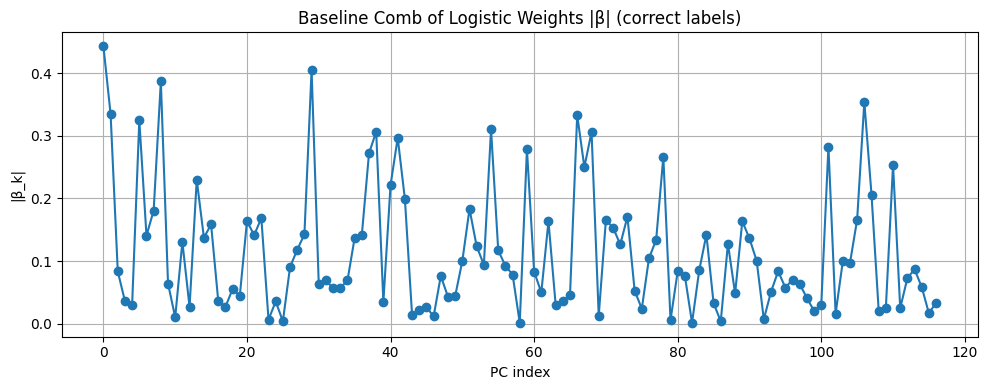

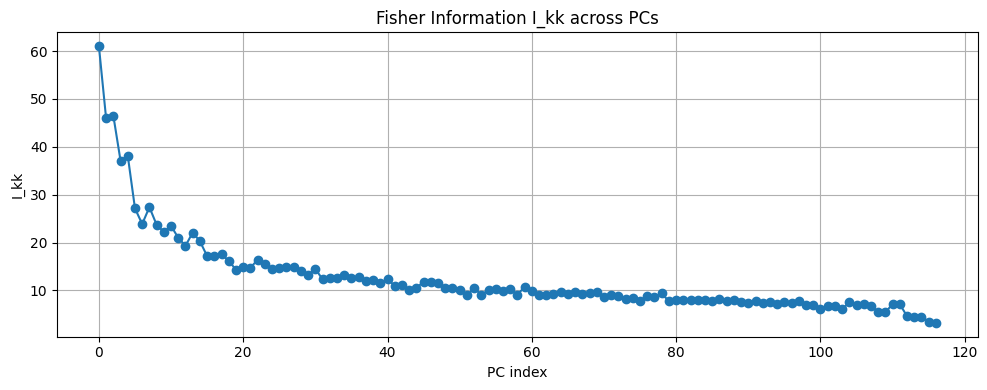

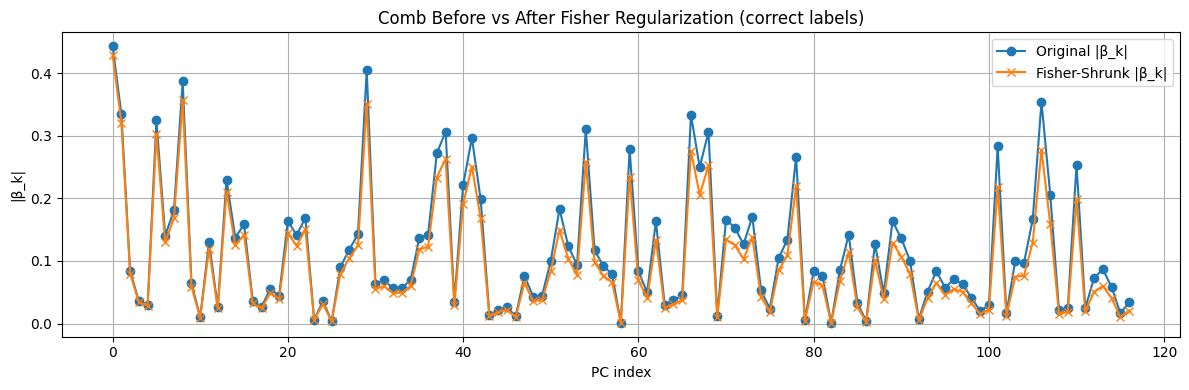

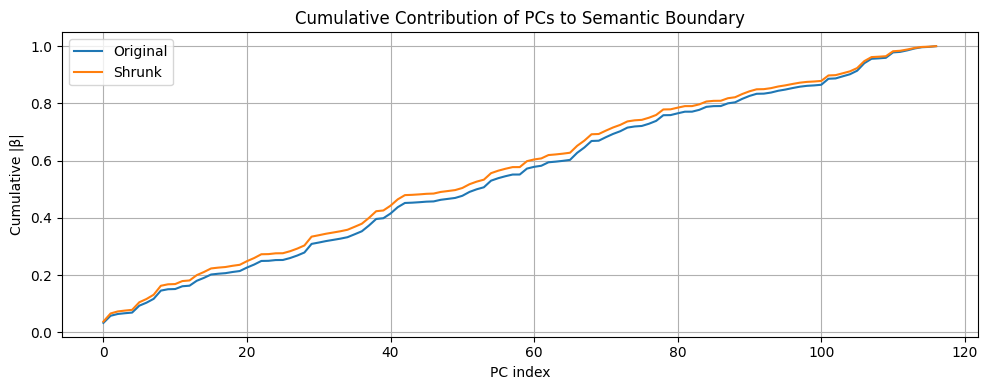

In [13]:
#https://chatgpt.com/c/6935dd2e-0820-8330-b048-06d71c27768a

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 0. Paths (from your message)
# ---------------------------------------------------------

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

# ---------------------------------------------------------
# 1. Load data
# ---------------------------------------------------------

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # dict or array depending on your file
R     = np.load(NEURAL_PATH)                                  # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)                  # (neurons,)

print("R shape (images, neurons):", R.shape)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ============================================================
# 1) LOAD YOUR DATA (already in workspace)
# R: neurons × images  → X: images × neurons
# vit: (images × classes)
# ============================================================

X = R.T.astype(float)   # (118 images, ~39k neurons)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)

print("X:", X.shape, "y mean:", y.mean())

# ============================================================
# 2) PCA on neural responses
# ============================================================

pca_dim = 117
pca = PCA(n_components=pca_dim, svd_solver="randomized")
Z = pca.fit_transform(X)     # (118 × pca_dim)

variances = pca.explained_variance_

print("Neural PCs:", Z.shape)

# ============================================================
# 3) Logistic regression in PC space (baseline comb)
# ============================================================

clf = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='liblinear',
    max_iter=500
)

clf.fit(Z, y)
beta = clf.coef_.ravel()
b0 = clf.intercept_[0]

# Plot baseline comb
plt.figure(figsize=(10,4))
plt.plot(np.abs(beta), marker='o')
plt.title("Baseline Comb of Logistic Weights |β| (correct labels)")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 4) Fisher information for logistic regression
# ============================================================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

g = Z @ beta + b0
p = sigmoid(g)
w_diag = p * (1 - p)         # N × 1

# Fisher matrix: F = Z^T diag(w) Z
F = (Z.T * w_diag) @ Z
fisher_diag = np.diag(F) + 1e-12   # avoid divide-by-zero

plt.figure(figsize=(10,4))
plt.plot(fisher_diag, marker='o')
plt.title("Fisher Information I_kk across PCs")
plt.xlabel("PC index")
plt.ylabel("I_kk")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 5) Fisher-weighted shrinkage
# ============================================================

lambda_reg = 2.0      # you can sweep this later

beta_shrunk = beta / (1 + lambda_reg / fisher_diag)

# ============================================================
# 6) COMPARE combs: baseline vs Fisher-regularized
# ============================================================

plt.figure(figsize=(12,4))
plt.plot(np.abs(beta), label="Original |β_k|", marker='o')
plt.plot(np.abs(beta_shrunk), label="Fisher-Shrunk |β_k|", marker='x')
plt.title("Comb Before vs After Fisher Regularization (correct labels)")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 7) Cumulative contribution to the decision boundary
# ============================================================

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(np.abs(beta)) / np.sum(np.abs(beta)), label="Original")
plt.plot(np.cumsum(np.abs(beta_shrunk)) / np.sum(np.abs(beta_shrunk)), label="Shrunk")
plt.title("Cumulative Contribution of PCs to Semantic Boundary")
plt.xlabel("PC index")
plt.ylabel("Cumulative |β|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Power-law exponent ~ -0.5340085140875759


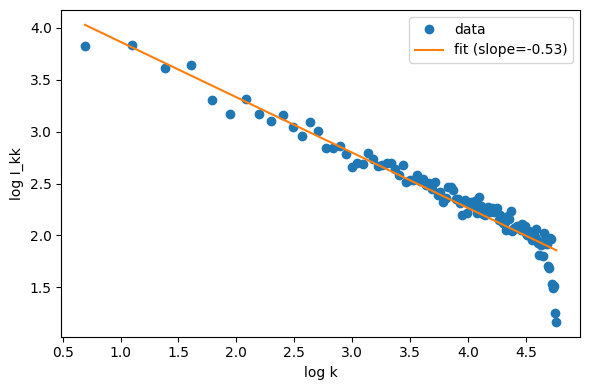

In [14]:
import numpy as np
import matplotlib.pyplot as plt

I = fisher_diag  # from earlier
k = np.arange(1, len(I) + 1)

# Keep only PCs with positive info and away from extreme tail
mask = (I > 0) & (k >= 2)    # skip k=1 if you want
k_fit = k[mask]
I_fit = I[mask]

logk = np.log(k_fit)
logI = np.log(I_fit)

# Fit line: log I = a + b log k  => I ~ k^b
b, a = np.polyfit(logk, logI, 1)

print("Power-law exponent ~", b)

# Plot
plt.figure(figsize=(6,4))
plt.plot(logk, logI, 'o', label='data')
plt.plot(logk, a + b*logk, '-', label=f'fit (slope={b:.2f})')
plt.xlabel("log k")
plt.ylabel("log I_kk")
plt.legend()
plt.tight_layout()
plt.show()


X: (118, 39209) y mean (real): 0.5338983050847458
Using: SHUFFLED LABELS
PCs: (118, 117)


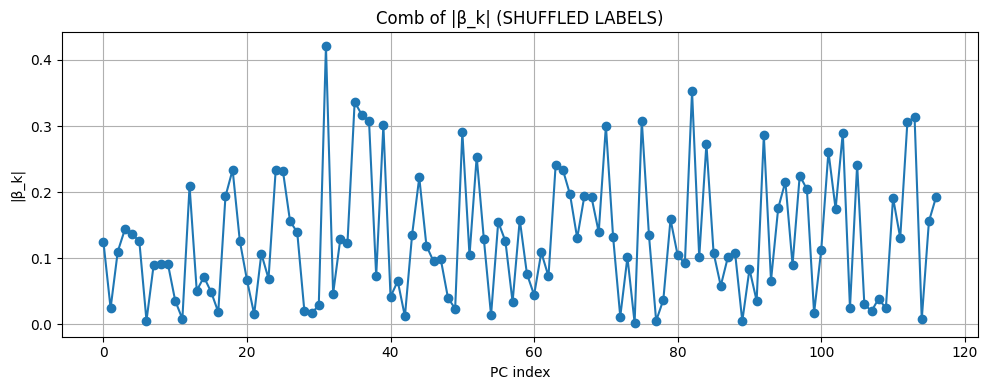

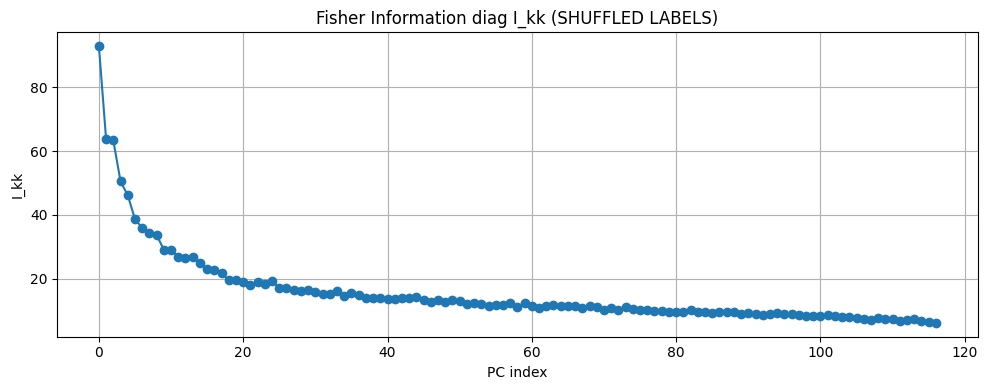

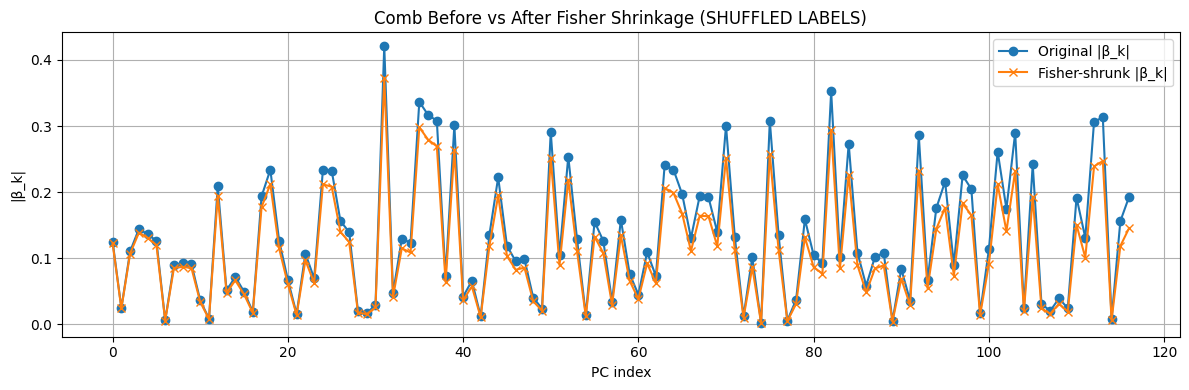

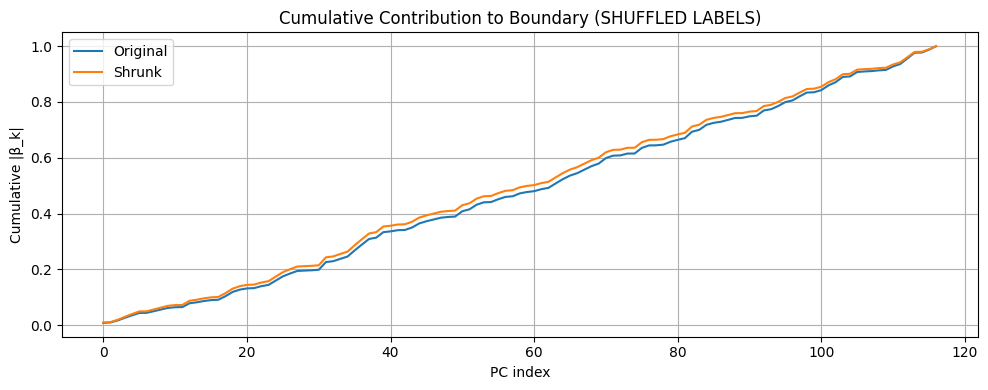

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ============================================================
# 0) LOAD DATA
# ============================================================

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

X = R.astype(float)                 # (images × neurons)
top1 = np.argmax(vit, axis=1)
y_real = (top1 <= 397).astype(int)  # animate/inanimate label

print("X:", X.shape, "y mean (real):", y_real.mean())


# ============================================================
# 1) SWITCH HERE: REAL LABELS OR SHUFFLED LABELS
# ============================================================

shuffle_labels = True   # ⬅️ CHANGE THIS

if shuffle_labels:
    rng = np.random.default_rng(0)
    y = rng.permutation(y_real)
    label_tag = "SHUFFLED LABELS"
else:
    y = y_real.copy()
    label_tag = "REAL LABELS"

print("Using:", label_tag)


# ============================================================
# 2) PCA ON NEURAL DATA
# ============================================================

pca_dim = X.shape[0] - 1  # maximum PCs (118 images → 117 PCs)
pca = PCA(n_components=pca_dim, svd_solver="randomized")
Z = pca.fit_transform(X)     # (images × PCs)
print("PCs:", Z.shape)

# ============================================================
# 3) LOGISTIC REGRESSION IN PC SPACE
# ============================================================

clf = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='liblinear',
    max_iter=2000
)

clf.fit(Z, y)

beta = clf.coef_.ravel()
b0   = clf.intercept_[0]

# Plot comb
plt.figure(figsize=(10,4))
plt.plot(np.abs(beta), marker='o')
plt.title(f"Comb of |β_k| ({label_tag})")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# 4) FISHER INFORMATION (IMPORTANT part)
# ============================================================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

g = Z @ beta + b0
p = sigmoid(g)
w_diag = p * (1 - p)    # (images,)

# Fisher = Zᵀ diag(w) Z
F = (Z.T * w_diag) @ Z
fisher_diag = np.diag(F) + 1e-12   # avoid div0

plt.figure(figsize=(10,4))
plt.plot(fisher_diag, marker='o')
plt.title(f"Fisher Information diag I_kk ({label_tag})")
plt.xlabel("PC index")
plt.ylabel("I_kk")
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# 5) FISHER-WEIGHTED SHRINKAGE
# ============================================================

lambda_reg = 2.0

beta_shrunk = beta / (1 + lambda_reg / fisher_diag)

plt.figure(figsize=(12,4))
plt.plot(np.abs(beta), label="Original |β_k|", marker='o')
plt.plot(np.abs(beta_shrunk), label="Fisher-shrunk |β_k|", marker='x')
plt.title(f"Comb Before vs After Fisher Shrinkage ({label_tag})")
plt.xlabel("PC index")
plt.ylabel("|β_k|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# 6) CUMULATIVE IMPORTANCE
# ============================================================

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(np.abs(beta)) / np.sum(np.abs(beta)), label="Original")
plt.plot(np.cumsum(np.abs(beta_shrunk)) / np.sum(np.abs(beta_shrunk)), label="Shrunk")
plt.title(f"Cumulative Contribution to Boundary ({label_tag})")
plt.xlabel("PC index")
plt.ylabel("Cumulative |β_k|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


X shape: N=118 images, P=39209 neurons
Label balance (real): 0.5338983050847458
PC space Z: (118, 117)

=== REAL LABELS ===
Accuracy (in-sample): 1.0
||beta_real||: 1.657165042472333
Fisher along beta (I_beta_real): 15.814246539557939

=== SHUFFLED LABELS (NULL) ===
Null mean accuracy: 1.0 ± 0.0
Null mean I_beta:   12.99219886627633 ± 0.41192572481634254

Permutation p-value for I_beta: 0.0


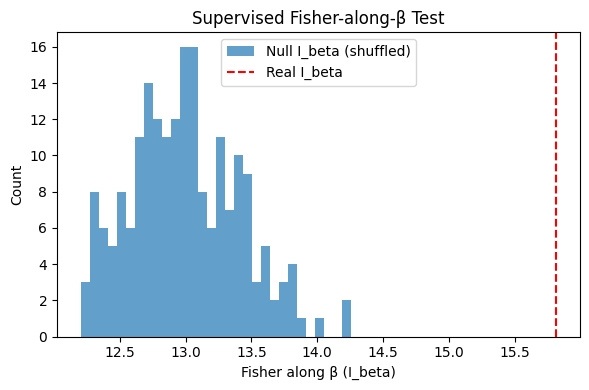

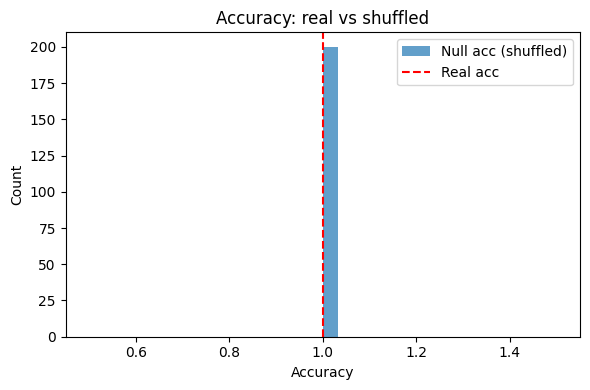

In [ ]:
#https://chatgpt.com/g/g-p-676c80353b988191819d6d02aca806d6-msc-thesis/c/6938741f-262c-832f-bbd3-13d5dedd0600

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ============================================================
# 0) LOAD DATA
# ============================================================

VIT_PATH    = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

vit   = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R     = np.load(NEURAL_PATH).T
areas = np.load(AREAS_PATH, allow_pickle=True)

# X: images × neurons
X = R.astype(float)
N, P = X.shape
print(f"X shape: N={N} images, P={P} neurons")

# Animate / inanimate labels from ViT top-1
top1   = np.argmax(vit, axis=1)
y_real = (top1 <= 397).astype(int)
print("Label balance (real):", y_real.mean())


# ============================================================
# 1) PCA ON NEURAL DATA
# ============================================================

pca_dim = N - 1           # max PCs: N images → N-1 PCs
pca = PCA(n_components=pca_dim, svd_solver="randomized")
Z = pca.fit_transform(X)  # shape: (N, pca_dim)
print("PC space Z:", Z.shape)


# ============================================================
# 2) UTILITIES: LOGISTIC + FISHER + I_beta
# ============================================================

def fit_logreg_and_fisher(y, Z):
    """
    Fits L2 logistic regression on Z, returns:
    - accuracy
    - beta (weights)
    - Fisher matrix F
    - Fisher along beta: I_beta = v^T F v  with v = beta / ||beta||
    """
    clf = LogisticRegression(
        penalty='l2',
        C=0.1,
        solver='liblinear',
        max_iter=5000
    )
    clf.fit(Z, y)

    beta = clf.coef_.ravel()
    b0   = clf.intercept_[0]

    # Accuracy (in-sample; for this test it's just a sanity check)
    y_pred = clf.predict(Z)
    acc = accuracy_score(y, y_pred)

    # Fisher: F = Z^T diag(w) Z, w_i = p_i (1 - p_i)
    g = Z @ beta + b0
    p = 1.0 / (1.0 + np.exp(-g))
    w = p * (1.0 - p)

    F = (Z.T * w) @ Z          # (d × d)

    # Direction of decision boundary
    beta_norm = np.linalg.norm(beta)
    if beta_norm < 1e-12:
        I_beta = 0.0
    else:
        v = beta / beta_norm   # unit vector
        I_beta = float(v @ (F @ v))

    return acc, beta, F, I_beta


# ============================================================
# 3) REAL LABELS: I_beta_real
# ============================================================

acc_real, beta_real, F_real, I_beta_real = fit_logreg_and_fisher(y_real, Z)

print("\n=== REAL LABELS ===")
print("Accuracy (in-sample):", acc_real)
print("||beta_real||:", np.linalg.norm(beta_real))
print("Fisher along beta (I_beta_real):", I_beta_real)


# ============================================================
# 4) SHUFFLED LABELS: NULL DISTRIBUTION OF I_beta
# ============================================================

n_perm = 200
rng = np.random.default_rng(0)
I_beta_null = []
acc_null = []

for i in range(n_perm):
    y_shuf = rng.permutation(y_real)
    acc_s, beta_s, F_s, I_beta_s = fit_logreg_and_fisher(y_shuf, Z)
    I_beta_null.append(I_beta_s)
    acc_null.append(acc_s)

I_beta_null = np.array(I_beta_null)
acc_null = np.array(acc_null)

print("\n=== SHUFFLED LABELS (NULL) ===")
print("Null mean accuracy:", acc_null.mean(), "±", acc_null.std())
print("Null mean I_beta:  ", I_beta_null.mean(), "±", I_beta_null.std())

# p-value: how many null I_beta >= real I_beta
p_value = np.mean(I_beta_null >= I_beta_real)
print("\nPermutation p-value for I_beta:", p_value)


# ============================================================
# 5) PLOTS
# ============================================================

# Histogram of null I_beta with real marked
plt.figure(figsize=(6,4))
plt.hist(I_beta_null, bins=30, alpha=0.7, label="Null I_beta (shuffled)")
plt.axvline(I_beta_real, color="red", linestyle="--", label="Real I_beta")
plt.xlabel("Fisher along β (I_beta)")
plt.ylabel("Count")
plt.title("Supervised Fisher-along-β Test")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: compare accuracies
plt.figure(figsize=(6,4))
plt.hist(acc_null, bins=30, alpha=0.7, label="Null acc (shuffled)")
plt.axvline(acc_real, color="red", linestyle="--", label="Real acc")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.title("Accuracy: real vs shuffled")
plt.legend()
plt.tight_layout()
plt.show()
